In [44]:
import numpy as np
import pandas as pd# Import cleaned dataset

import seaborn as sb
sb.set(font_scale=2) # set the default Seaborn style for graphics
import matplotlib.pyplot as plt # we only need pyplot

# For model training
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


In [19]:
news_data = pd.read_csv("cleaned_news_data.csv")

In [20]:
news_data.shape

(44898, 30)

In [21]:
# view the dataframe 
news_data.head()

,Unnamed: 0,title,text,subject,label,label_meaning,port_title,port_text,snow_title,snow_text,...,title_pos_noun,title_pos_num,title_pos_pron,title_pos_verb,text_pos_adj,text_pos_adv,text_pos_noun,text_pos_num,text_pos_pron,text_pos_verb
0,0,kremlin us embassy move jerusalem may worsen i...,moscow reuters kremlin said wednesday russia c...,worldnews,1,True,kremlin us embassi move jerusalem may worsen i...,moscow reuter kremlin said wednesday russia co...,kremlin us embassi move jerusalem may worsen i...,moscow reuter kremlin said wednesday russia co...,...,3,0,1,3,7,2,28,0,3,16
1,1,boom watch vp candidate tim kaine skirt issue ...,nice try obvious tim kaine covering hillary la...,politics,0,False,boom watch vp candid tim kain skirt issu clint...,nice tri obviou tim kain cover hillari lack tr...,boom watch vp candid tim kain skirt issu clint...,nice tri obvious tim kain cover hillari lack t...,...,10,0,0,1,3,0,5,0,0,1
2,2,ussaudi plan let 9000 isis fighters walk free ...,patrick henningsen 21st century wirejudging wo...,us_news,0,False,ussaudi plan let 9000 isi fighter walk free mo...,patrick henningsen 21st centuri wirejudg word ...,ussaudi plan let 9000 isi fighter walk free mo...,patrick henningsen 21st centuri wirejudg word ...,...,6,1,0,2,241,65,500,15,42,235
3,3,sarah huckabeesanders destroys room full fake ...,white house deputy press secretary sarah hucka...,politics,0,False,sarah huckabeesand destroy room full fake news...,white hous deputi press secretari sarah huckab...,sarah huckabeesand destroy room full fake news...,white hous deputi press secretari sarah huckab...,...,10,0,0,2,38,7,143,8,0,56
4,4,french arrest nine swiss one joint antiterrori...,paris reuters french police arrested nine peop...,worldnews,1,True,french arrest nine swiss one joint antiterror ...,pari reuter french polic arrest nine peopl ano...,french arrest nine swiss one joint antiterror ...,pari reuter french polic arrest nine peopl ano...,...,2,2,0,0,45,7,96,11,0,51


In [23]:
# Init tfidvectorizer
tfidf = TfidfVectorizer(stop_words='english',
                        strip_accents=None,
                        lowercase=True,
                        preprocessor=None,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=False, max_features=15000)

In [24]:
# TF-IDF extraction of top n features
def tfidf_top_n_features(tfidf_data, features, n):
    # TFIDF data is the term document matrix without the names, and features are the term names
    # Convert np.array into dataframe (Currently, headers are the features and rows are the score per document)
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns = features)
    # Transpose dataframe so that the headers are the documents and the x axis is the feature name
    tfidf_df = tfidf_df.transpose()
    # Average all document tfidf scores into 1 column
    tfidf_means = np.mean(tfidf_df, axis=1)
    # Previous code output is series data, convert back into df with headers
    tfidf_df_summed = pd.DataFrame({'feature':tfidf_means.index, 'avg_tfidf':tfidf_means.values})
    # Sort to top N features
    tfidf_df_summed = tfidf_df_summed.sort_values(by='avg_tfidf', ascending=False)[:n]
    
    return tfidf_df_summed

In [27]:
# Init tfidvectorizer again for training with different parameters
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

# Send all docs to fit
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [31]:
lr = LogisticRegressionCV(solver='liblinear', random_state=0, max_iter=300)


In [33]:
# Init Stratified K fold cross validation object
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Run k-fold using logistic regression
cv_results = cross_val_score(lr, tfidf_train, y_train, cv=sf)

In [34]:
# Print performance of each training and the average training score
for score in cv_results:
    print(f"Score: {score :.5f}")

print(f"Mean score: {cv_results.mean() :.5f}")

Score: 0.94893
Score: 0.94671
Score: 0.95323
Score: 0.94543
Score: 0.94924
Mean score: 0.94871


In [35]:
# Train
lr.fit(tfidf_train, y_train)

LogisticRegressionCV(max_iter=300, random_state=0, solver='liblinear')

<Axes: >

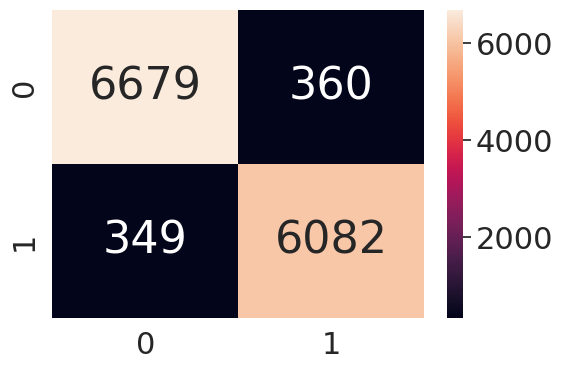

In [36]:
# Predict test dataset
y_test_pred = lr.predict(tfidf_test)

# Print confusion matrix
f = plt.figure(figsize=(6,4))
sb.heatmap(cm:=confusion_matrix(y_test, y_test_pred), annot = True, fmt=".0f", annot_kws={"size": 32})

In [37]:
# Get overall accuracy
print("Test Data")
print("Accuracy  :\t", lr.score(tfidf_test, y_test))
print("")

# Get individual accuracy
tpTest = cm[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cm[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cm[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cm[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))

print("\nFPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

Test Data
Accuracy  :	 0.9473645137342243

TPR Test :	 0.9457316125019437
TNR Test :	 0.9488563716436994

FPR Test :	 0.05114362835630061
FNR Test :	 0.05426838749805629


In [38]:
# Print classification report
cr = classification_report(y_test, y_test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7039
           1       0.94      0.95      0.94      6431

    accuracy                           0.95     13470
   macro avg       0.95      0.95      0.95     13470
weighted avg       0.95      0.95      0.95     13470



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9f23536d-6e62-418a-b94b-ca9356b2599b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>